<a href="https://colab.research.google.com/github/zaq9/simpleOption/blob/master/example_graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install git+https://github.com/zaq9/simpleOption

In [4]:
#from simpleOption import *

import numpy as np
% matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')


In [16]:
import QuantLib as qb
from parse import parse


class Date(qb.Date):
    def __init__(self, intDate):
        self.name = str(intDate)
        year = int(self.name[0:4])
        month = int(self.name[4:6])
        date = int(self.name[6:8])
        super().__init__(date, month, year)

def sqDate(strSQDate):
    """Returns :SQ_Date(qb.Date)
    Parameters
    type1(monthly):  '02'
    type2(weekly) :  '02w3'
    """

    month = int(strSQDate[0:2])
    week = 2 if len(strSQDate) < 2 else int(strSQDate[-1])
    year = qb.Date.todaysDate().year()  # todo:check otherCase
    return qb.Date.nthWeekday(week, 6, month, year)


# init marketData
u = qb.SimpleQuote(20040)
r = qb.SimpleQuote(0.01)
sigma = qb.SimpleQuote(25 / 100)


def setEvaluationDate(date): qb.Settings.instance().setEvaluationDate(date)


def setting(
        underlying=None,
        iv=None,
        evaluationDate=None,
        rate=None):
    """ Market Data Setting """
    if underlying is not None: u.setValue(float(underlying))
    if iv is not None: sigma.setValue(float(iv) / 100)
    if rate is not None: r.setValue(float(rate))
    if evaluationDate is not None: setEvaluationDate(Date(evaluationDate))


def view():
    print(f"EvaluationDate={qb.Settings.instance().evaluationDate}")
    print(f"u={u.value()}")
    print(f"iv={sigma.value()}")


riskFreeCurve = qb.FlatForward(0, qb.Japan(), qb.QuoteHandle(r), qb.Actual360())
volatility = qb.BlackConstantVol(0, qb.Japan(), qb.QuoteHandle(sigma), qb.Actual360())
process = qb.BlackScholesProcess(qb.QuoteHandle(u),
                                 qb.YieldTermStructureHandle(riskFreeCurve),
                                 qb.BlackVolTermStructureHandle(volatility))
engine = qb.AnalyticEuropeanEngine(process)


class Payoff(qb.PlainVanillaPayoff):
    def __init__(self, strPayoff):
        self.name = strPayoff
        x = parse("{op_type}{strike:d}", strPayoff)
        super().__init__(
            qb.Option.Call if x['op_type'] == 'C' else qb.Option.Put, x['strike'])

    def __str__(self): return self.name


class Option(qb.EuropeanOption):
    def __init__(self, strOption):
        self.name = strOption
        x = parse("{sq_date}/{payoff}", strOption)
        self.payoff = Payoff(x['payoff'])
        super().__init__(
            self.payoff, qb.EuropeanExercise(sqDate(x['sq_date'])))
        self.setPricingEngine(engine)

    def __str__(self): return self.name

    def v(self, underlying=None, iv=None, evoluationDate=None):
        setting(underlying, iv, evoluationDate)
        return self.NPV()

    def pay(self, underlying): return self.payoff(float(underlying))


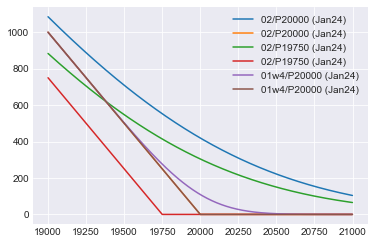

In [18]:
# sample base graph
x = np.arange(19000, 21000)
setting(20250, 26, 20190124)
for s in ['02/P20000', '02/P19750', '01w4/P20000']:
    plt.plot(x, np.vectorize(Option(s).v)(x), label=s + ' (Jan24)')
    plt.plot(x, np.vectorize(Option(s).pay)(x), label=s + ' (Jan24)')
plt.legend(loc="best")
plt.show()
